# Do we perform better if we train locally vs. globally ?

In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
# colormaps = https://matplotlib.org/cmocean/
import cmocean
import matplotlib.pyplot as plt
import geopandas as gpd
from typing import List, Tuple, Dict, Union, Optional

import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 100

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

%load_ext autoreload
%autoreload 2

In [2]:
from scripts.utils import get_data_path
from src.engineer import Engineer
from src.utils import get_ds_mask
from src.utils import drop_nans_and_flatten

In [3]:
data_dir = get_data_path()
EXPERIMENT = experiment = "one_month_forecast"

# Load in the experiments

In [4]:
from src.analysis import read_train_data, read_test_data, read_pred_data
from scripts.analysis import (
    read_all_data, 
    read_all_available_pred_data, 
    load_nn, 
    create_all_error_metrics, 
    create_matching_shapes_in_predictions_dict, 
    extract_json_results_dict
)

In [5]:
X_train, y_train, X_test, y_test = read_all_data(
    data_dir, experiment=experiment, 
)

In [6]:
mask = get_ds_mask(X_train.VCI)

In [7]:
predictions = read_all_available_pred_data(data_dir, experiment=experiment)
preds = predictions["rnn_0"]
predictions = {"rnn": preds}

# #  check that the shapes of all predictions are the same
# if not set([predictions[m].shape for m in predictions.keys()]).__len__() == 1:
#     predictions = create_matching_shapes_in_predictions_dict(
#         predictions,
#         verbose=True
#     )
    
# assert set([predictions[m].shape for m in predictions.keys()]).__len__() == 1
# preds = predictions[list(m for m in predictions.keys())[-1]]

# get the matching shapes from predictions and test data
test_da = y_test[list(y_test.data_vars)[0]]
test_da = test_da.sel(lat=preds.lat, lon=preds.lon, time=preds.time)

## Calculate Error Metrics

In [8]:
rmse_dict, r2_dict = create_all_error_metrics(predictions, test_da)

In [9]:
rnn_total, rnn_df = extract_json_results_dict(
    data_dir=data_dir,
    model="rnn_0",
    experiment=experiment
)

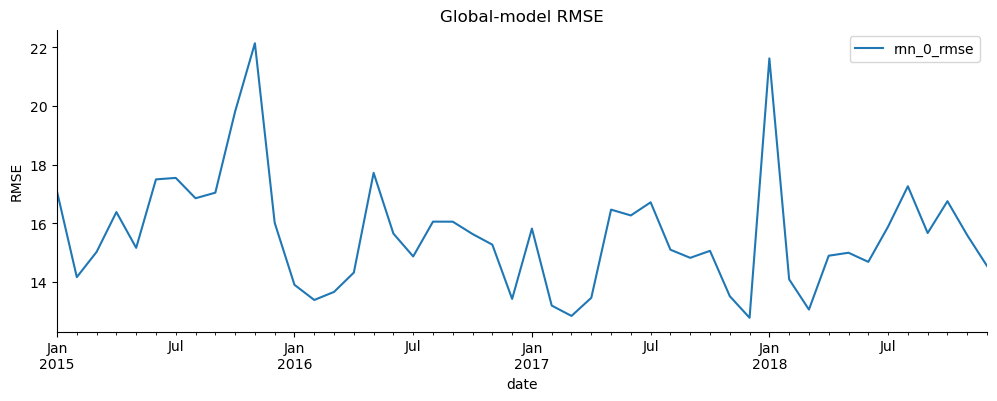

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
rnn_df.set_index("date")[["rnn_0_rmse"]].plot(ax=ax)
ax.set_ylabel("RMSE")
ax.set_title("Global-model RMSE")
sns.despine()

# Load in experiment Results

In [11]:
"""
open_the_experiment_csv_files
open_region_specific_xr
get_matching_dims
join_region_das_into_one_xr_obj
create_local_global_errors
"""

# https://stackoverflow.com/questions/9090079/in-python-how-to-import-filename-starts-with-a-number
__import__("scripts.experiments.23_spatial_mask_local_train");

In [12]:
global_da = pred_da = preds

In [13]:
def open_region_specific_xr() -> xr.DataArray:
    region_lstms = [d.name for d in (data_dir / "models/region_expt").glob("*_rnn")]
    dataarrays = {}

    for lstm in region_lstms:
        region_name = lstm.split("_rnn")[0].split(":")[-1][7:]
        _, da = read_pred_data(data_dir=data_dir, experiment="region_expt", model=lstm)
        dataarrays[region_name] = da

    return dataarrays


def join_region_das_into_one_xr_obj(dataarrays: Dict[str, xr.DataArray]) -> xr.DataArray:
    df = pd.concat([da.to_dataframe() for da in [d for d in dataarrays.values()]], axis=0)
    # drop duplicate rows!
    df = df.groupby(level=df.index.names).mean()
    # df[~df.index.duplicated()].to_xarray()
    da = df.to_xarray()["preds"]
    return da


def get_matching_dims(ref_da, other_da) -> Tuple[xr.DataArray]:
    lats = ref_da.lat.values
    lons = ref_da.lon.values
    times = ref_da.time.values

    other_da = other_da.sel(lat=lats, lon=lons, time=times)

    # also mask out missing values
    ref_mask = ref_da.isnull()
    other_da = other_da.where(~ref_mask)
    return ref_da, other_da


def open_the_experiment_csv_files() -> pd.DataFrame:
    data_dir = get_data_path()
    df = pd.concat(
        [
            pd.read_csv(d).drop("Unnamed: 0", axis=1)
            for d in (data_dir / "models/region_expt/").glob("*.csv")
        ]
    )
    return df

In [14]:
from src.analysis import read_pred_data, spatial_rmse, spatial_r2


def create_local_global_errors(local_da, global_da, test_da) -> Tuple[Dict[str, xr.DataArray]]:
    _region_da, _test_da = get_matching_dims(local_da, test_da)
    _, _global_da = get_matching_dims(local_da, global_da)

    r2_dict = {}
    rmse_dict = {}

    for experiment, pred_da in zip(["local", "global"], [_region_da, _global_da]):
        experiment_rmse = spatial_rmse(
            _test_da.transpose("time", "lat", "lon"),
            pred_da.transpose("time", "lat", "lon"),
        )
        experiment_rmse.name = "rmse"
        rmse_dict[experiment] = experiment_rmse

        experiment_r2 = spatial_r2(
            _test_da.transpose("time", "lat", "lon"),
            pred_da.transpose("time", "lat", "lon"),
        )
        experiment_r2.name = "r2"
        r2_dict[experiment] = experiment_r2

    return r2_dict, rmse_dict


In [15]:
# ra, ta = get_matching_dims(da, test_da)
# ra, pa = get_matching_dims(da, pred_da)
das = open_region_specific_xr()
local_da = join_region_das_into_one_xr_obj(das)
r2_dict, rmse_dict = create_local_global_errors(local_da, global_da=pred_da, test_da=test_da)

# r2_dict, rmse_dict = create_local_global_errors(pred_da, test_da)

/home/tommy/ml_drought/src/analysis/evaluation.py:54: RuntimeWarning: invalid value encountered in true_divide
  r2_vals = 1 - (np.nansum((true_da.values - pred_da.values) ** 2, axis=0)) / (


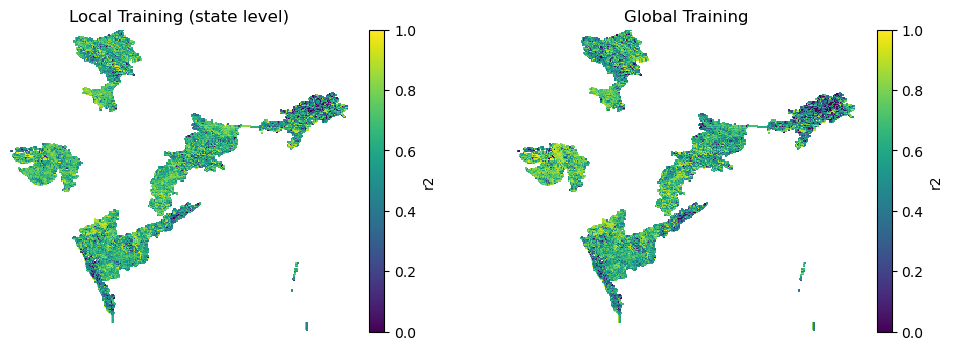

In [16]:
kwargs = dict(vmin=0, vmax=1)

fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

r2_dict['local'].plot(ax=axs[0], cbar_kwargs={'extend':'neither'}, **kwargs)
axs[0].set_title("Local Training (state level)")
axs[0].axis('off');

r2_dict['global'].plot(ax=axs[1], cbar_kwargs={'extend':'neither'}, **kwargs)
axs[1].set_title("Global Training")
axs[1].axis('off');

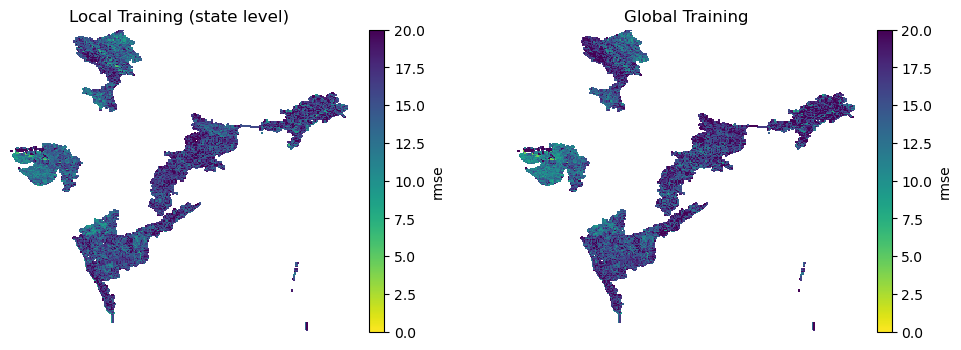

In [17]:
kwargs = dict(vmin=0, vmax=20, cmap="viridis_r")

fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

rmse_dict['local'].plot(ax=axs[0], cbar_kwargs={'extend':'neither'}, **kwargs)
axs[0].set_title("Local Training (state level)")
axs[0].axis('off');

rmse_dict['global'].plot(ax=axs[1], cbar_kwargs={'extend':'neither'}, **kwargs)
axs[1].set_title("Global Training")
axs[1].axis('off');

# State vs. Global

In [18]:
l1_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm1.shp")

region_csvs = open_the_experiment_csv_files()
region_csvs["date"] = pd.to_datetime(region_csvs["date"])
region_csvs.head()

,rnn_rmse,date_str,date,region
0,14.865378,2015_1,2015-01-31,Andaman and Nicobar
1,10.884583,2015_2,2015-02-28,Andaman and Nicobar
2,11.816936,2015_3,2015-03-31,Andaman and Nicobar
3,14.893158,2015_4,2015-04-30,Andaman and Nicobar
4,19.682398,2015_5,2015-05-31,Andaman and Nicobar


In [19]:
global_data = rnn_df.set_index("date")[["rnn_0_rmse"]].rename(dict(rnn_0_rmse="Global"), axis=1)

for ix, region in enumerate(region_csvs.region.unique()):
    fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))

    ax = axs[0]
    local_data = region_csvs[region_csvs["region"] == region].set_index("date")[["rnn_rmse"]].rename(dict(rnn_rmse="Local"), axis=1)
    local_data.plot(ax=ax)
    global_data.plot(ax=ax, label="Global Experiment", alpha=0.8, color="k", ls="--")   
    ax.set_ylabel("RMSE")
    ax.set_ylim(0, 40)

    ax = axs[1]
    l1_gdf.plot(color='grey', ax=ax, alpha=0.7)
    l1_gdf.query(f"NAME_1 == '{region}'").plot(ax=ax)
    ax.set_title(region)
    ax.axis('off')
    sns.despine()
    
    fig.savefig(data_dir / f"tommy/region_plots/{ix:03}_region_timeseries_vals.png")
    plt.close()

In [20]:
!convert -delay 100 /cats/datastore/data/tommy/region_plots/*png /cats/datastore/data/tommy/region_plots/animation.gif

Text(0.5, 1.0, 'Global vs. Region RMSEs')

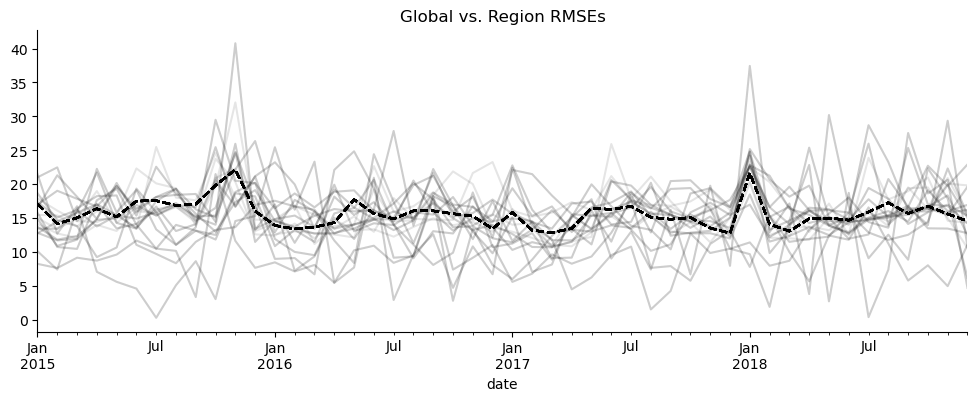

In [21]:
global_data = rnn_df.set_index("date")[["rnn_0_rmse"]].rename(dict(rnn_0_rmse="Global"), axis=1)
fig, ax = plt.subplots(figsize=(12, 4))

for ix, region in enumerate(region_csvs.region.unique()):
    local_data = region_csvs[region_csvs["region"] == region].set_index("date")[["rnn_rmse"]].rename(dict(rnn_rmse="Local"), axis=1)
    global_data.plot(ax=ax, alpha=1, color="k", ls="--")   
    local_data.plot(ax=ax, alpha=0.1, color="k")
    ax.get_legend().remove()

sns.despine()
ax.set_title("Global vs. Region RMSEs")

# global_data

In [22]:
from sklearn.metrics import mean_squared_error


def capitalize_string_exceptions(string: str) -> str:
    import re
    exceptions = ["and", "or", "the", "a", "of", "in"]

    lowercase_words = re.split("_", string.lower())
    final_words = [lowercase_words[0].capitalize()]

    final_words += [word if word in exceptions else word.capitalize() for word in lowercase_words[1:]]
    return " ".join(final_words)


global_subsets = {}
subsets = []
for region_name, _region_da in das.items():
    _, test_subset = get_matching_dims(_region_da, test_da)
    _, global_subset = get_matching_dims(_region_da, global_da)
    
    # convert to dataframe
    _df = global_subset.to_dataframe().join(test_subset.to_dataframe())
    # create RMSE for each timestep
    _df = (_df.reset_index().dropna().groupby("time").apply(lambda x: np.sqrt(mean_squared_error(x.VCI, x.preds))).reset_index().rename({0: "rnn_rmse"}, axis=1))
    _df["region"] = capitalize_string_exceptions(region_name)
    subsets.append(_df)

# global
global_csvs = pd.concat(subsets)
global_csvs["date"] = pd.to_datetime(global_csvs["time"])

In [23]:
# # get mean pixel rmse per time
# _df = global_subset.to_dataframe().join(test_subset.to_dataframe())
# _df = (
#     _df.reset_index().dropna()
#     .groupby("time")
#     .apply(lambda x: np.sqrt(mean_squared_error(x.VCI, x.preds)))
#     .reset_index()
#     .rename({0: "rnn_rmse"}, axis=1)
# )
print(global_csvs.columns)
print(region_csvs.columns)

Index(['time', 'rnn_rmse', 'region', 'date'], dtype='object')
Index(['rnn_rmse', 'date_str', 'date', 'region'], dtype='object')


In [24]:
for ix, region in enumerate(global_csvs["region"].unique()):
#     global_csvs
#     region_csvs
    
    fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
    ax = axs[0]
    global_csvs.query(f"region == '{region}'").set_index("date")[["rnn_rmse"]].rename(dict(rnn_rmse="Global"), axis=1).plot(ax=ax, color="k", ls="--", alpha=0.8)
    region_csvs.query(f"region == '{region}'").set_index("date")[["rnn_rmse"]].rename(dict(rnn_rmse="Local"), axis=1).plot(ax=ax, color=sns.color_palette()[1])
    
    ax = axs[1]
    l1_gdf.plot(color='grey', ax=ax, alpha=0.7)
    l1_gdf.query(f"NAME_1 == '{region}'").plot(ax=ax)
    ax.set_title(region)
    ax.axis('off')
    sns.despine()

    fig.savefig(data_dir / f"tommy/region_ts_plots/{ix:03}_region_timeseries_vals.png")
    plt.close()

In [25]:
!convert -delay 100 /cats/datastore/data/tommy/region_ts_plots/*png /cats/datastore/data/tommy/region_ts_plots/animation.gif

### What about the difference?

In [31]:
for ix, region in enumerate(global_csvs["region"].unique()):
#     global_csvs
#     region_csvs
    
    fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
    ax = axs[0]
    _global_data = global_csvs.query(f"region == '{region}'").set_index("date")[["rnn_rmse"]].rename(dict(rnn_rmse="Global"), axis=1)
    _region_data = region_csvs.query(f"region == '{region}'").set_index("date")[["rnn_rmse"]].rename(dict(rnn_rmse="Local"), axis=1)
#     ax.plot(np.arange(len(_global_data)), _global_data["Global"], color="k", ls="--", alpha=0.5, label="Global")
#     ax.plot(np.arange(len(_region_data)), _region_data["Local"], color="k", alpha=0.5, label="Local")
    difference = (_global_data["Global"] - _region_data["Local"])
    
    # plot the differences as bar chart
    color = [sns.color_palette()[1] if d <= 0 else sns.color_palette()[0] for d in difference]
    ax.bar(x=np.arange(len(_global_data)), height=difference, color=color)
    _global_data["Global"] - _region_data["Local"]
    ax.set_ylabel("$Global_{RMSE} - Local_{RMSE}$")
    ax.set_ylim(-19, 19)
    ax.set_xticklabels([])
    ax.set_xlabel("Time")

    ax = axs[1]
    l1_gdf.plot(color='grey', ax=ax, alpha=0.7)
    l1_gdf.query(f"NAME_1 == '{region}'").plot(ax=ax)
    ax.set_title(region)
    ax.axis('off')
    sns.despine()

    fig.savefig(data_dir / f"tommy/diff_region_plots/{ix:03}_region_rmse_diff_timeseries.png")
    plt.close()

In [32]:
!convert -delay 100 /cats/datastore/data/tommy/diff_region_plots/*png /cats/datastore/data/tommy/diff_region_plots/animation.gif

In [33]:
all_diffs = pd.DataFrame({"init": [0 for _ in global_csvs.date.unique()]}, index=global_csvs.date.unique())
for ix, region in enumerate(global_csvs["region"].unique()):
    _global_data = global_csvs.query(f"region == '{region}'").set_index("date")[["rnn_rmse"]].rename(dict(rnn_rmse="Global"), axis=1)
    _region_data = region_csvs.query(f"region == '{region}'").set_index("date")[["rnn_rmse"]].rename(dict(rnn_rmse="Local"), axis=1)

    difference = (_global_data["Global"] - _region_data["Local"])
    all_diffs[region] = difference


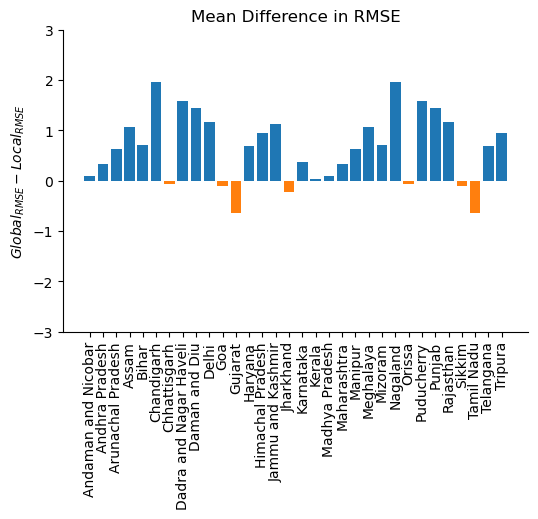

In [34]:
data = all_diffs.drop("init", axis=1).mean(axis=0).reset_index().rename({0:"difference"}, axis=1)
color = [sns.color_palette()[1] if d <= 0 else sns.color_palette()[0] for d in data["difference"]]
fig, ax = plt.subplots()

ax.bar(x=data["index"], height=data["difference"], color=color)
ax.set_xticklabels(data["index"], rotation=90);
ax.set_ylim((-3, 3))
ax.set_ylabel("$Global_{RMSE} - Local_{RMSE}$")
ax.set_title("Mean Difference in RMSE")
sns.despine()